In [3]:
from models import *
from utils import *
import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [8]:
config_path='config/yolov3.cfg'
weights_path='config/yolov3.weights'
class_path='config/coco.names'
img_size=416
conf_thres=0.8
nms_thres=0.4
# Load model and weights
print(type (model))
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
#model.cuda()
model.eval()
classes = utils.load_classes(class_path)
#Tensor = torch.cuda.FloatTensor
Tensor = torch.FloatTensor

<class 'models.Darknet'>


In [13]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms=transforms.Compose([transforms.Resize((imh,imw)),
         transforms.Pad((max(int((imh-imw)/2),0), 
              max(int((imw-imh)/2),0), max(int((imh-imw)/2),0),
              max(int((imw-imh)/2),0)), (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, 
                        conf_thres, nms_thres)
    return detections[0]

Inference Time: 0:00:00.776295


TypeError: random_sample() takes at most 1 positional argument (2 given)

<Figure size 432x288 with 0 Axes>

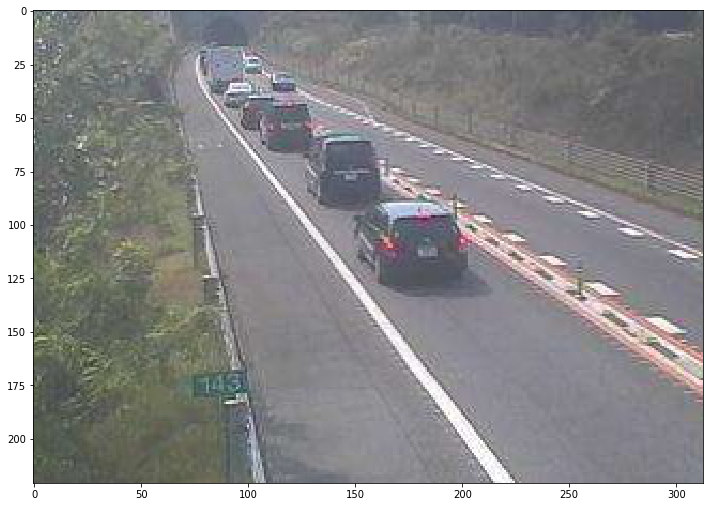

In [67]:
# load image and get detections
img_path = "images/road2.jpg"
prev_time = time.time()
img = Image.open(img_path)
detections = detect_image(img)
inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print ('Inference Time: %s' % (inference_time))
# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]
img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)
pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x
if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(
             unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h,
             linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=classes[int(cls_pred)], 
                color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
plt.axis('off')
# save image
plt.savefig(img_path.replace(".jpg", "-det.jpg"),        
                  bbox_inches='tight', pad_inches=0.0)
plt.show()

In [66]:
!pip install filterpy

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


tensor([[354.3895, 129.7340, 392.5123, 153.9861,   0.9988,   0.9964,   2.0000],
        [244.7541, 169.0010, 304.6159, 211.7792,   0.9986,   0.9721,   2.0000],
        [290.3308, 105.7556, 313.4839, 124.0028,   0.9924,   0.9880,   2.0000],
        [162.9400, 152.9554, 202.9278, 191.4073,   0.9911,   0.5110,   2.0000],
        [355.5175, 187.7878, 417.6599, 240.3645,   0.9875,   0.9415,   2.0000],
        [265.0964, 103.0893, 285.2417, 116.7527,   0.9868,   0.9977,   2.0000],
        [165.1194, 110.8238, 181.9231, 124.7813,   0.9865,   0.9990,   2.0000],
        [310.1228, 134.7958, 343.2746, 175.0552,   0.9826,   0.8095,   2.0000],
        [141.8060, 119.8628, 164.1062, 140.4895,   0.9778,   0.9902,   2.0000],
        [134.9114, 100.9563, 148.4589, 109.5759,   0.9466,   0.9977,   2.0000],
        [202.2431, 185.4412, 264.2441, 246.1590,   0.9993,   0.5140,   5.0000],
        [ 97.6731, 118.6725, 141.6826, 182.0747,   0.9398,   0.9912,   5.0000],
        [164.4539, 151.9486, 202.8836, 1

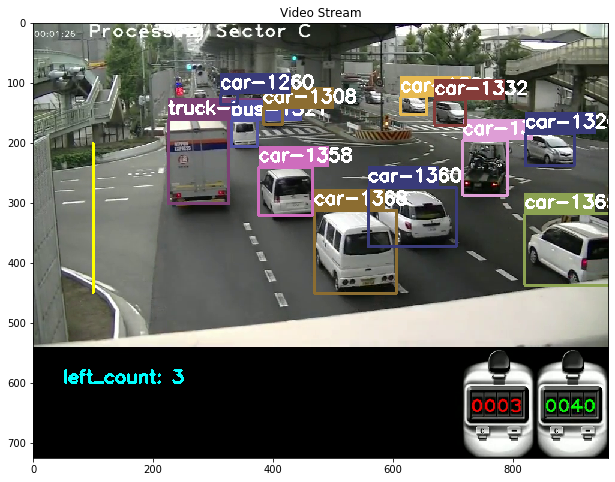

In [64]:
videopath = 'videos/traffic_count_day.mp4'

%pylab inline 
import cv2
from IPython.display import clear_output

cmap = plt.get_cmap('tab20b')
colors = [cmap(i)[:3] for i in np.linspace(0, 1, 20)]

# initialize Sort object and video capture
from sort import *
vid = cv2.VideoCapture(videopath)
mot_tracker = Sort() 

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('output.mp4', fourcc, 30.0, (960,726))

left_counter = set()

#while(True):
for ii in range(900):
    ret, frame = vid.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pilimg = Image.fromarray(frame)
    detections = detect_image(pilimg)

    img = np.array(pilimg)
    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x
    if detections is not None:
        print(detections.cpu())
        tracked_objects = mot_tracker.update(detections.cpu())
        print(tracked_objects)

        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        for x1, y1, x2, y2, obj_id, cls_pred in tracked_objects:
            box_h = int(((y2 - y1) / unpad_h) * img.shape[0])
            box_w = int(((x2 - x1) / unpad_w) * img.shape[1])
            y1 = int(((y1 - pad_y // 2) / unpad_h) * img.shape[0])
            x1 = int(((x1 - pad_x // 2) / unpad_w) * img.shape[1])

            color = colors[int(obj_id) % len(colors)]
            color = [i * 255 for i in color]
            cls = classes[int(cls_pred)]
            cv2.rectangle(frame, (x1, y1), (x1+box_w, y1+box_h), color, 4)
            cv2.rectangle(frame, (x1, y1-35), (x1+len(cls)*19+60, y1), color, -1)
            cv2.putText(frame, cls + "-" + str(int(obj_id)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)
            
            if y2 >= 200 and y2 <= 450 and x2 <= 100:
                left_counter.add(obj_id) 
            
        cv2.line(frame, (100, 200), (100, 450), (255, 255, 0), 4)
        cv2.putText(frame, "left_count: " + str(len(left_counter)), (50, 600), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,255), 3)
        out.write(frame)

    fig=figure(figsize=(12, 8))
    title("Video Stream")
    imshow(frame)
    show()
    clear_output(wait=True)

out.release()

In [2]:
import torch
PyTorch

NameError: name 'PyTorch' is not defined